In [0]:
%matplotlib inline

In [0]:
!unzip top_bottom.zip 

Archive:  top_bottom.zip
   creating: top_bottom/
   creating: top_bottom/top/
  inflating: top_bottom/top/cam1_1571263442.0599256.png  
   creating: __MACOSX/
   creating: __MACOSX/top_bottom/
   creating: __MACOSX/top_bottom/top/
  inflating: __MACOSX/top_bottom/top/._cam1_1571263442.0599256.png  
  inflating: top_bottom/top/cam1_1571263356.8525283.png  
  inflating: __MACOSX/top_bottom/top/._cam1_1571263356.8525283.png  
  inflating: top_bottom/top/cam1_1571263380.1144812.png  
  inflating: __MACOSX/top_bottom/top/._cam1_1571263380.1144812.png  
  inflating: top_bottom/top/cam0_1571918882.6631627.png  
  inflating: __MACOSX/top_bottom/top/._cam0_1571918882.6631627.png  
  inflating: top_bottom/top/cam1_1571918860.3654847.png  
  inflating: __MACOSX/top_bottom/top/._cam1_1571918860.3654847.png  
  inflating: top_bottom/top/cam1_1571918849.509133.png  
  inflating: __MACOSX/top_bottom/top/._cam1_1571918849.509133.png  
  inflating: top_bottom/top/cam1_1571918849.0128906.png  
  inflat

In [0]:
!ls -al

total 33756
drwxr-xr-x 1 root root     4096 Oct 17 03:11 .
drwxr-xr-x 1 root root     4096 Oct 17 03:12 ..
drwxr-xr-x 1 root root     4096 Oct 11 15:15 .config
drwxr-xr-x 4 root root     4096 Oct 16 16:07 eyegaze_new
-rw-r--r-- 1 root root 34533348 Oct 17 02:35 eyegaze_new.zip
drwxr-xr-x 2 root root     4096 Oct 17 03:10 .ipynb_checkpoints
drwxrwxr-x 4 root root     4096 Oct 17 02:49 __MACOSX
-rw-r--r-- 1 root root     1757 Oct 17 02:53 preprocessing.py
drwxr-xr-x 1 root root     4096 Aug 27 16:17 sample_data


In [0]:
!rm -rf eyegaze

In [0]:
!unzip eyegaze_new.zip

Archive:  eyegaze_new.zip
   creating: eyegaze_new/
   creating: eyegaze_new/train/
   creating: eyegaze_new/train/right/
  inflating: eyegaze_new/train/right/cam1_1571222899.4468696.png  
   creating: __MACOSX/eyegaze_new/
   creating: __MACOSX/eyegaze_new/train/
   creating: __MACOSX/eyegaze_new/train/right/
  inflating: __MACOSX/eyegaze_new/train/right/._cam1_1571222899.4468696.png  
  inflating: eyegaze_new/train/right/cam1_1571263356.8525283.png  
  inflating: __MACOSX/eyegaze_new/train/right/._cam1_1571263356.8525283.png  
  inflating: eyegaze_new/train/right/cam1_1571263410.4148123.png  
  inflating: __MACOSX/eyegaze_new/train/right/._cam1_1571263410.4148123.png  
  inflating: eyegaze_new/train/right/cam1_1571222985.3329613.png  
  inflating: __MACOSX/eyegaze_new/train/right/._cam1_1571222985.3329613.png  
  inflating: eyegaze_new/train/right/cam0_1571262372.384637.png  
  inflating: __MACOSX/eyegaze_new/train/right/._cam0_1571262372.384637.png  
  inflating: eyegaze_new/train/r

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'top_bottom'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

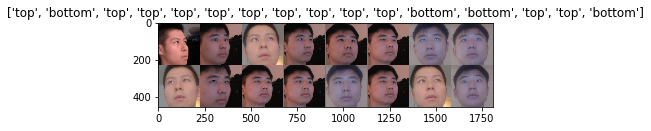

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    train_loss_list = list()
    train_acc_list = list()
    val_loss_list = list()
    val_acc_list = list()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print("???",epoch_acc)
            if phase == 'train':
              train_loss_list.append(epoch_loss)
              train_acc_list.append(epoch_acc.item())
            else:
              val_loss_list.append(epoch_loss)
              val_acc_list.append(epoch_acc.item())
              print(val_acc_list)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    print(val_acc_list)    
    return model,train_loss_list,train_acc_list,val_loss_list, val_acc_list

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  True: {}'.format(class_names[preds[j]], class_names[labels.data[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.MobileNetV2(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.6MB/s]


In [0]:
model_ft, train_loss_list,train_acc_list,val_loss_list, val_acc_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)


Epoch 0/29
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5681 Acc: 0.7160
??? tensor(0.7160, device='cuda:0', dtype=torch.float64)
val Loss: 0.5713 Acc: 0.7538
??? tensor(0.7538, device='cuda:0', dtype=torch.float64)
[0.7538461538461538]

Epoch 1/29
----------
train Loss: 0.4405 Acc: 0.7743
??? tensor(0.7743, device='cuda:0', dtype=torch.float64)
val Loss: 0.5129 Acc: 0.7769
??? tensor(0.7769, device='cuda:0', dtype=torch.float64)
[0.7538461538461538, 0.7769230769230769]

Epoch 2/29
----------
train Loss: 0.3515 Acc: 0.8366
??? tensor(0.8366, device='cuda:0', dtype=torch.float64)
val Loss: 0.4386 Acc: 0.8077
??? tensor(0.8077, device='cuda:0', dtype=torch.float64)
[0.7538461538461538, 0.7769230769230769, 0.8076923076923077]

Epoch 3/29
----------
train Loss: 0.2553 Acc: 0.9086
??? tensor(0.9086, device='cuda:0', dtype=torch.float64)
val Loss: 0.5287 Acc: 0.7154
??? tensor(0.7154, device='cuda:0', dtype=torch.float64)
[0.7538461538461538, 0.7769230769230769, 0.8076923076923077, 0.7153846153846154]

Epoch 4/29
----------
train Lo

In [0]:
print(train_acc_list)
print(val_acc_list[0].item())

[tensor(0.9758, device='cuda:0', dtype=torch.float64), tensor(0.9709, device='cuda:0', dtype=torch.float64)]
0.9134615384615385


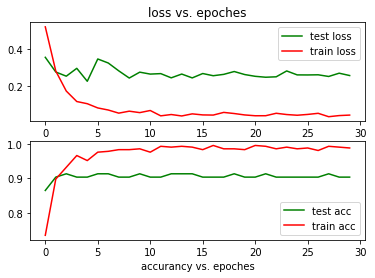

In [0]:
x = range(0, len(val_loss_list))


plt.subplot(2, 1, 1)
plt.plot(x, val_loss_list, color="green", label = "test loss")
plt.plot(x, train_loss_list, color="red", label = "train loss")
plt.title('loss vs. epoches')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(x, val_acc_list, color="green",label = "test acc")
plt.plot(x, train_acc_list, color="red",label = "train acc")
plt.xlabel('accurancy vs. epoches')
plt.legend()
plt.show()

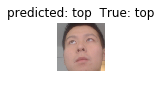

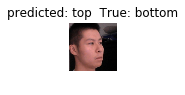

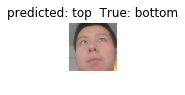

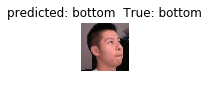

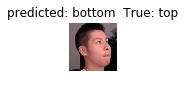

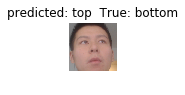

In [0]:
visualize_model(model_ft)